# Integrated Mean Squared Prediction Error

This notebook shows the `crit_IMSPE` functionality, based on the example from the `hetGP` R library.


Suppose, given a trained GP, we wish to minimize global predictive variance over our potential input space $X$. In this case our acquisition function would be the Integrated Mean-Squared Prediction Error [Gramacy (2020) Ch. 10.3.1](https://bookdown.org/rbg/surrogates/chap10.html#chap10imspe):

\begin{align*}
I_{n+1}(x_{n+1}) \equiv \mathrm{IMSPE}(\bar{x}_1, \dots, \bar{x}_n, x_{n+1}) = \int_{x \in \mathcal{X}} \breve{\sigma}^2_{n+1}(x) \, dx
\end{align*}

Where $\breve{\sigma}^2_{n+1}(x)$ is the nugget-free predictive uncertainty.

As mentioned in [Gramacy (2020) Ch. 10.3.1](https://bookdown.org/rbg/surrogates/chap10.html#chap10imspe) such an integral often requires numerical evaluation, but conditional on GP hyperparameters, and if the domain of $X$ is a hyperrectangle (such as $[0,1]$ which is often done when modeling with GPs), then IMSPE can be calculated in closed form:

\begin{align}
I_{n+1}(x_{n+1}) &= \mathbb{E} \{ \breve{\sigma}^2_{n+1}(X) \} = \mathbb{E} \{K_\theta(X, X) - k_{n+1}^\top(X) K_{n+1}^{-1} k_{n+1}(X) \} \\
&= \mathbb{E} \{K_\theta(X,X)\} - \mathrm{tr}(K_{n+1}^{-1} W_{n+1})
\end{align}

Where $W_{ij} = \int_{x \in \mathcal{X}} k(x_i, x) k(x_j, x)\, dx$ which exists in closed form when $X$ is a hyperrectangle. For example, [Binois et. al (2019)](https://arxiv.org/pdf/1710.03206) show the case for a separable Gaussian kernel:

\begin{align*}
W_{ij}= \prod_{k=1}^m \dfrac{\sqrt{2\pi \theta_k} }{4} \exp\left\{-\dfrac{(x_{ik}-x_{jk})^2}{2 \theta_k}\right\}  
\left[\mathrm{erf}\left\{\dfrac{2-(x_{ik}+x_{jk})}{\sqrt{2 \theta_k}}\right\}+ \mathrm{erf}\left\{\dfrac{x_{ik}+x_{jk}}{\sqrt{ 2\theta_k}}\right\} \right].
\end{align*}

And note that $\mathrm{erf}$ is the [error function](https://en.wikipedia.org/wiki/Error_function).

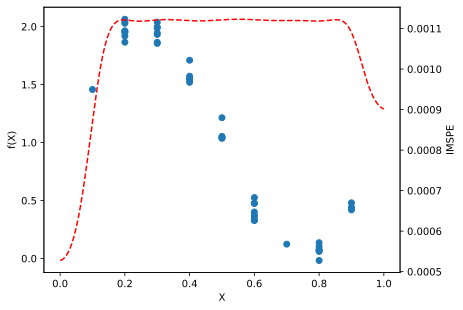

In [2]:
%config InlineBackend.figure_formats = ['svg']
from hetgpy.IMSE import crit_IMSPE, Wij
from hetgpy import hetGP
from hetgpy.find_reps import find_reps
import numpy as np
import matplotlib.pyplot as plt

random = np.random.default_rng(42)
def ftest(x, coef = 0.1):
    return np.sin(2 * np.pi * x) + random.normal(loc = 1, scale = coef)

n = 9
designs = np.linspace(0.1, 0.9,n).reshape(-1,1)
reps = random.choice(1 + np.arange(10), size = n)

X = designs[np.repeat(np.arange(n),reps)]
Z = np.array([ftest(x) for x in X]).squeeze()
model = hetGP()
model.mle(
    X = X,
    Z = Z, 
    lower = np.array([0.1]), 
    upper = np.array([5]),
    known = {},
    init = {})

fig, ax = plt.subplots()
ax.scatter(X,Z)
ax.set_xlabel('X')
ax.set_ylabel('f(X)')
ngrid = 501
xgrid = np.linspace(0,1,ngrid).reshape(-1,1)

## Precalculations
Wijs = Wij(mu1 = model.X0, theta = model.theta, type = model.covtype)
IMSPE_grid = np.array([crit_IMSPE(x,model=model,Wijs=Wijs) for x in xgrid])
ax2 = ax.twinx()
ax2.plot(xgrid.squeeze(),IMSPE_grid.squeeze(),'r--')
ax2.set_ylabel('IMSPE');

Note that in this case, the IMSPE is minimized at the edge of our input domain ($x=0$).